# Курс Спортивный анализ данных. Платформа Kaggle

# Практическое задание урока 7. Тюнинг гиперпараметров, построение ансамблей алгоритмов

Чтобы было больше времени на выполнение курсовой работы, задание выполнить на наборе данных для соревнования:
Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.

1.	Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.
2.	Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.
3.	Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.
4.	Выполнить задание 2 для трех моделей.
5.	(опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.
6.	(опция) Обучить алгоритм RandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [1]:
import time
import numpy as np
import pandas as pd
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gmean

from pathlib import Path

pd.set_option('display.max_columns', None)

In [2]:
def get_input(dataset_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.
    
    Parametrs
    ---------
    dataset_path: str
        Название файла
        
    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame
    """
    
    data_root = Path('D:/DS_materials/208_kaggle/data_comp/')
    dataset = pd.read_csv(f'{data_root}/{dataset_path}')
    dataset.columns = [col.lower() for col in dataset.columns]
    print(f"{dataset_path} shape: {dataset.shape[0]} rows, {dataset.shape[1]} cols")

    return dataset

In [3]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    if categorical:
        X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [4]:
def xgboost_cross_validation(params, fit_params, X, y, cv):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            **fit_params
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [5]:
def lightgbm_cross_validation(params, fit_params, X, y, cv):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    #X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            **fit_params
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [6]:
def encode_cat_feats(train, test, categorial):
    for feature in categorial:
        le = LabelEncoder()
        train[feature] = le.fit_transform(train[feature].fillna('null'))
        test[feature] = le.transform(test[feature].fillna('null'))
    return train, test

In [7]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()
        
        
    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
            )


    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']

    X["ratio_salary_to_per_family_size"] = X["total_salary"] / X["family_size"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение временных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

    """
    # Сделать конкатенацию признаков, рассматривая их как категориальные
    features_1 = ['childrens', 'family_size']
    for feature in features_1:
        X[feature] = X[feature].astype('str')
    
    X["gender_childrens"] = X['gender'] + " | " + X['childrens']
    X["gender_family_status"] = X['gender'] + " | " + X['family_status']    
    X["gender_family_size"] = X['gender'] + " | " + X['family_size'] 
    X["gender_childrens_family_status"] = X['gender_childrens'] + " | " + X['family_status']  
    X["gender_childrens_family_size"] = X['gender_childrens'] + " | " + X['family_size']   
    X["gender_family_status_family_size"] = X['gender_family_status'] + " | " + X['family_size']       
    X["family_status_family_size"] = X['family_status'] + " | " + X['family_size']  
    X["childrens_family_size"] = X['childrens'] + " | " + X['family_size']
    X["childrens_family_status"] = X['childrens'] + " | " + X['family_status']  
    X["childrens_family_status_family_size"] = X['childrens'] + " | " + X['family_status_family_size']  
    """
    
    # Сделать FrequencyEncoder для категориальных признаков
    features_2 = ['gender', 'childrens', 'family_status', 'family_size']   
    for feature in features_2:
        freq_enc = X[feature].value_counts(normalize=True)
        X[feature + "_freq_enc"] = X[feature].map(freq_enc)    
          
    return X

# Подготовка датасета

In [8]:
train = get_input("train.csv")
test = get_input("test.csv")

data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)
data.head(n=2)

train.csv shape: 110093 rows, 3 cols
test.csv shape: 165141 rows, 2 cols


,application_number,target,name_contract_type
0,123687442,0.0,Cash
1,123597908,1.0,Cash


In [9]:
client_profile = get_input("client_profile.csv")
client_profile = create_client_profile_features(client_profile)
client_profile.head(n=2)

client_profile.csv shape: 250000 rows, 24 cols


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_salary_to_per_family_size,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,gender_freq_enc,childrens_freq_enc,family_status_freq_enc,family_size_freq_enc
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549.0,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0,3.0,1.428571,0.052832,2.930959,0.236315,0.678568,0.414784,0.329471,0.036237,20.00000,0.085714,1.714286,78750.0,1.577103,31.542056,18.399533,101.678502,174.306004,8.7153,5.526146,1270.71,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797,0.65858,0.70004,0.097008,0.514472
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,NaN,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-1.875000,NaN,NaN,0.442295,0.802745,0.622520,0.622520,0.032481,18.86105,0.105433,1.988583,135000.0,1.227714,23.155971,11.644456,NaN,NaN,NaN,NaN,5466.42,NaN,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462,0.65858,0.70004,0.639384,0.514472


In [10]:
data = data.merge(
    client_profile, how="left", on="application_number"
)

In [11]:
mask = data["target"].isnull()
features_to_drop = ["application_number", "target"]

train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

categorial = train.dtypes[train.dtypes == "object"].index
numerical = list(set(train.columns) - set(categorial))

train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)

In [12]:
train_encode, test_encode = encode_cat_feats(train, test, categorial)

## Задание 1
Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

In [13]:
seed = 42
np.random.seed(seed)

cv = KFold(n_splits=5, random_state=1234123, shuffle=True)

### LightGBM model

In [14]:
lgbm_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "objective": "binary",
    "boosting_type": "gbdt",    
    "max_bin": 20,
    "max_depth": 6,
    "random_seed": seed
}
lgbm_fit_params = {
    "eval_metric": "auc",
    "early_stopping_rounds": 50,
    "verbose": 50
}


lgbm_estimators, lgbm_oof_preds = lightgbm_cross_validation(
    params=lgbm_params, fit_params=lgbm_fit_params, X=train_encode, y=target, cv=cv
)

Sat Oct 30 22:27:40 2021, Cross-Validation, 110093 rows, 57 cols
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.720913	training's binary_logloss: 0.262911	valid_1's auc: 0.702475	valid_1's binary_logloss: 0.274015
[100]	training's auc: 0.729627	training's binary_logloss: 0.256255	valid_1's auc: 0.707372	valid_1's binary_logloss: 0.268708
[150]	training's auc: 0.736012	training's binary_logloss: 0.252428	valid_1's auc: 0.709847	valid_1's binary_logloss: 0.266229
[200]	training's auc: 0.741844	training's binary_logloss: 0.2499	valid_1's auc: 0.712157	valid_1's binary_logloss: 0.264895
[250]	training's auc: 0.747422	training's binary_logloss: 0.247822	valid_1's auc: 0.71508	valid_1's binary_logloss: 0.264005
[300]	training's auc: 0.752743	training's binary_logloss: 0.246025	valid_1's auc: 0.716881	valid_1's binary_logloss: 0.263393
[350]	training's auc: 0.757574	training's binary_logloss: 0.244463	valid_1's auc: 0.718231	valid_1's binary_logloss: 0.263

In [15]:
# Score by each fold: [0.71987, 0.72287, 0.73048, 0.721, 0.72514]

lgbm_oof_score = roc_auc_score(
    target, lgbm_oof_preds
)
print(f"OOF-score = {round(lgbm_oof_score, 5)}")
# OOF-score = 0.72286

OOF-score = 0.72286


### XGBoost model

In [16]:
xgb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "max_bin": 20,
    "max_depth": 6,
    "nthread": 6,
    "seed": seed
}
xgb_fit_params = {
    "early_stopping_rounds": 50,
    "verbose":50,    
    "eval_metric": "auc"    
}

xgb_estimators, xgb_oof_preds = xgboost_cross_validation(
    params=xgb_params, fit_params=xgb_fit_params, X=train_encode, y=target, cv=cv
)

Sat Oct 30 22:28:49 2021, Cross-Validation, 110093 rows, 57 cols


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.70718	validation_1-auc:0.69074
[50]	validation_0-auc:0.72979	validation_1-auc:0.70027
[100]	validation_0-auc:0.73670	validation_1-auc:0.70180
[150]	validation_0-auc:0.74275	validation_1-auc:0.70298
[200]	validation_0-auc:0.75051	validation_1-auc:0.70576
[250]	validation_0-auc:0.75551	validation_1-auc:0.70859
[300]	validation_0-auc:0.76198	validation_1-auc:0.71080
[350]	validation_0-auc:0.76922	validation_1-auc:0.71343
[400]	validation_0-auc:0.77623	validation_1-auc:0.71428
[450]	validation_0-auc:0.78350	validation_1-auc:0.71605
[500]	validation_0-auc:0.79011	validation_1-auc:0.71851
[550]	validation_0-auc:0.79577	validation_1-auc:0.72015
[600]	validation_0-auc:0.80038	validation_1-auc:0.72054
[650]	validation_0-auc:0.80399	validation_1-auc:0.72105
[700]	validation_0-auc:0.80760	validation_1-auc:0.72157
[750]	validation_0-auc:0.81029	validation_1-auc:0.72216
[800]	validation_0-auc:0.81349	validation_1-auc:0.72187
[831]	validation_0-auc:0.81494	validation_1-auc:0.7

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.70677	validation_1-auc:0.69640
[50]	validation_0-auc:0.72887	validation_1-auc:0.70707
[100]	validation_0-auc:0.73381	validation_1-auc:0.70756
[150]	validation_0-auc:0.73873	validation_1-auc:0.71065
[200]	validation_0-auc:0.74658	validation_1-auc:0.71351
[250]	validation_0-auc:0.75191	validation_1-auc:0.71552
[300]	validation_0-auc:0.75979	validation_1-auc:0.71887
[350]	validation_0-auc:0.76782	validation_1-auc:0.72167
[400]	validation_0-auc:0.77524	validation_1-auc:0.72257
[450]	validation_0-auc:0.78238	validation_1-auc:0.72435
[500]	validation_0-auc:0.78765	validation_1-auc:0.72590
[550]	validation_0-auc:0.79231	validation_1-auc:0.72692
[600]	validation_0-auc:0.79712	validation_1-auc:0.72740
[638]	validation_0-auc:0.80007	validation_1-auc:0.72739
Fold 2, Valid score = 0.72763


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.70523	validation_1-auc:0.69588
[50]	validation_0-auc:0.72659	validation_1-auc:0.70957
[100]	validation_0-auc:0.73378	validation_1-auc:0.71105
[150]	validation_0-auc:0.74013	validation_1-auc:0.71264
[200]	validation_0-auc:0.74623	validation_1-auc:0.71692
[250]	validation_0-auc:0.75292	validation_1-auc:0.72013
[300]	validation_0-auc:0.76050	validation_1-auc:0.72339
[350]	validation_0-auc:0.76735	validation_1-auc:0.72621
[400]	validation_0-auc:0.77428	validation_1-auc:0.72883
[450]	validation_0-auc:0.78101	validation_1-auc:0.73109
[500]	validation_0-auc:0.78714	validation_1-auc:0.73280
[550]	validation_0-auc:0.79260	validation_1-auc:0.73347
[600]	validation_0-auc:0.79733	validation_1-auc:0.73467
[650]	validation_0-auc:0.80120	validation_1-auc:0.73547
[700]	validation_0-auc:0.80431	validation_1-auc:0.73579
[739]	validation_0-auc:0.80652	validation_1-auc:0.73610
Fold 3, Valid score = 0.73625


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.70948	validation_1-auc:0.68769
[50]	validation_0-auc:0.72882	validation_1-auc:0.70053
[100]	validation_0-auc:0.73365	validation_1-auc:0.70339
[150]	validation_0-auc:0.74125	validation_1-auc:0.70610
[200]	validation_0-auc:0.74932	validation_1-auc:0.70738
[250]	validation_0-auc:0.75545	validation_1-auc:0.70898
[300]	validation_0-auc:0.76028	validation_1-auc:0.71193
[350]	validation_0-auc:0.76748	validation_1-auc:0.71460
[400]	validation_0-auc:0.77399	validation_1-auc:0.71734
[450]	validation_0-auc:0.78144	validation_1-auc:0.71884
[500]	validation_0-auc:0.78752	validation_1-auc:0.71982
[550]	validation_0-auc:0.79309	validation_1-auc:0.72135
[600]	validation_0-auc:0.79779	validation_1-auc:0.72213
[650]	validation_0-auc:0.80115	validation_1-auc:0.72293
[700]	validation_0-auc:0.80414	validation_1-auc:0.72341
[750]	validation_0-auc:0.80684	validation_1-auc:0.72375
[800]	validation_0-auc:0.80906	validation_1-auc:0.72414
[850]	validation_0-auc:0.81148	validation_1-auc:0.7

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.70842	validation_1-auc:0.69386
[50]	validation_0-auc:0.72713	validation_1-auc:0.70053
[100]	validation_0-auc:0.73517	validation_1-auc:0.70244
[150]	validation_0-auc:0.73988	validation_1-auc:0.70425
[200]	validation_0-auc:0.74681	validation_1-auc:0.70972
[250]	validation_0-auc:0.75297	validation_1-auc:0.71228
[300]	validation_0-auc:0.75939	validation_1-auc:0.71458
[350]	validation_0-auc:0.76757	validation_1-auc:0.71674
[400]	validation_0-auc:0.77517	validation_1-auc:0.71874
[450]	validation_0-auc:0.78240	validation_1-auc:0.72130
[500]	validation_0-auc:0.78817	validation_1-auc:0.72325
[550]	validation_0-auc:0.79380	validation_1-auc:0.72477
[600]	validation_0-auc:0.79852	validation_1-auc:0.72533
[650]	validation_0-auc:0.80200	validation_1-auc:0.72573
[700]	validation_0-auc:0.80489	validation_1-auc:0.72655
[750]	validation_0-auc:0.80787	validation_1-auc:0.72698
[789]	validation_0-auc:0.81006	validation_1-auc:0.72693
Fold 5, Valid score = 0.72702
Score by each fold: [

In [17]:
# Score by each fold: [0.72219, 0.72763, 0.73625, 0.7254, 0.72702]

xgb_oof_score = roc_auc_score(
    target, xgb_oof_preds
)
print(f"OOF-score = {round(xgb_oof_score, 5)}")
# OOF-score = 0.72668

OOF-score = 0.72668


### Prediction Correlation for LightGBM & XGBoost

In [18]:
scores_2 = pd.DataFrame({
    "lgbm": lgbm_oof_preds,
    "xgb": xgb_oof_preds,
})

corr_2 = scores_2.corr()
mask = np.zeros_like(corr_2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<ipython-input-18-2808fd249174>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_2, dtype=np.bool)


<AxesSubplot:>

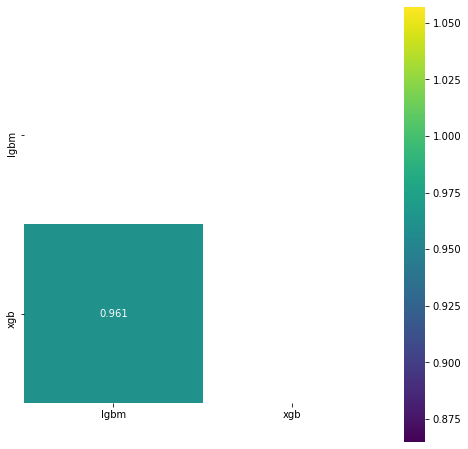

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr_2, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

### Test Correlation for LightGBM & XGBoost

In [20]:
def predict_by_estimators(test, estimators, test_id=test_id):
    y_pred = np.zeros(test.shape[0])

    for estimator in estimators:
        y_pred += estimator.predict_proba(test)[:, 1]
        
    y_pred = pd.DataFrame({
        "APPLICATION_NUMBER": test_id,
        "TARGET": y_pred / len(estimators)
    })
    return y_pred

In [21]:
xgb_test_preds = predict_by_estimators(test_encode, xgb_estimators)
lgbm_test_preds = predict_by_estimators(test_encode, lgbm_estimators)

In [22]:
scores_test_2 = pd.DataFrame({
    "lgbm": lgbm_test_preds["TARGET"],
    "xgb": xgb_test_preds["TARGET"],
})

corr_test_2 = scores_test_2.corr()
mask = np.zeros_like(corr_test_2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<ipython-input-22-d56a9182218a>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_test_2, dtype=np.bool)


<AxesSubplot:>

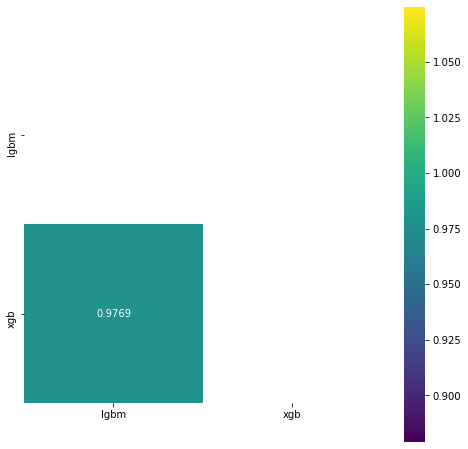

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr_test_2, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

**Вывод**
* Наблюдается высокая коррелляция между рассматриваемыми моделями LightGBM и XGBoost, что свидетельствует о схожей предсказательной силе.

## Задание 2
Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [24]:
scores_amean = scores_2.mean(axis=1)
auc_amean = roc_auc_score(target, scores_amean)
print(f"AMean Score = {round(auc_amean, 5)}")

scores_gmean = gmean(scores_2, axis=1)
auc_gmean = roc_auc_score(target, scores_gmean)
print(f"GMean Score = {round(auc_gmean, 5)}")

scores_rankdata = scores_2.rank().mean(axis=1)
auc_rankdata = roc_auc_score(target, scores_rankdata)
print(f"Rankdata Score = {round(auc_rankdata, 5)}")

scores_gmean_rankdata = gmean(scores_2.rank(), axis=1)
auc_gmean_rankdata = roc_auc_score(target, scores_gmean_rankdata)
print(f"GMean Rankdata Score = {round(auc_gmean_rankdata, 5)}")

AMean Score = 0.72584
GMean Score = 0.72576
Rankdata Score = 0.72584
GMean Rankdata Score = 0.72582


**Вывод**
* Качество на одиночных моделях составляет: LightGBM - 0.72286, XGBoost - 0.72668
* Качество усредненных прогнозов по двум моделям состаявляет AMean - 0.72584, GMean - 0.72576, Rankdata - 0.72584, GMean Rankdata - 0.72582 .
* Качество усредненных прогнозов по двум моделям близко друг к другу. 
* Качество на одиночной модели XGBoost выше, чем качество усредненных прогнозов по двум моделям и качество на одиночной модели LightGBM.

## Задание 3
Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

### CatBoost

In [26]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": seed
}

cb_estimators, cb_oof_preds = catboost_cross_validation(
    params=cb_params, X=train_encode, y=target, cv=cv, categorical=None
)

Sat Oct 30 23:01:08 2021, Cross-Validation, 110093 rows, 57 cols


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	test: 0.6676419	test1: 0.6565851	best: 0.6565851 (0)	total: 65ms	remaining: 2m 9s
10:	test: 0.7005791	test1: 0.6931642	best: 0.6931642 (10)	total: 773ms	remaining: 2m 19s
20:	test: 0.7025649	test1: 0.6953875	best: 0.6962007 (14)	total: 1.49s	remaining: 2m 20s
30:	test: 0.7049967	test1: 0.6972281	best: 0.6976513 (29)	total: 2.11s	remaining: 2m 13s
40:	test: 0.7059253	test1: 0.6975699	best: 0.6981486 (34)	total: 2.76s	remaining: 2m 11s
50:	test: 0.7072350	test1: 0.6990368	best: 0.6990368 (50)	total: 3.41s	remaining: 2m 10s
60:	test: 0.7073784	test1: 0.6988423	best: 0.6995232 (56)	total: 4s	remaining: 2m 7s
70:	test: 0.7082965	test1: 0.7002004	best: 0.7002004 (70)	total: 4.7s	remaining: 2m 7s
80:	test: 0.7087690	test1: 0.7010764	best: 0.7013132 (79)	total: 5.34s	remaining: 2m 6s
90:	test: 0.7099838	test1: 0.7022448	best: 0.7024455 (89)	total: 5.98s	remaining: 2m 5s
100:	test: 0.7109242	test1: 0.7032906	best: 0.7032906 (100)	total: 6.68s	remaining: 2m 5s
110:	test: 0.7112247	test1: 0.70

910:	test: 0.7445251	test1: 0.7215666	best: 0.7216965 (893)	total: 55.8s	remaining: 1m 6s
920:	test: 0.7449449	test1: 0.7216079	best: 0.7216965 (893)	total: 56.3s	remaining: 1m 6s
930:	test: 0.7452712	test1: 0.7215612	best: 0.7216965 (893)	total: 57s	remaining: 1m 5s
940:	test: 0.7456011	test1: 0.7217527	best: 0.7217527 (940)	total: 57.6s	remaining: 1m 4s
950:	test: 0.7458586	test1: 0.7216341	best: 0.7217527 (940)	total: 58.2s	remaining: 1m 4s
960:	test: 0.7460429	test1: 0.7217038	best: 0.7217527 (940)	total: 58.8s	remaining: 1m 3s
970:	test: 0.7464212	test1: 0.7217419	best: 0.7218205 (963)	total: 59.3s	remaining: 1m 2s
980:	test: 0.7465616	test1: 0.7218198	best: 0.7218205 (963)	total: 59.9s	remaining: 1m 2s
990:	test: 0.7468043	test1: 0.7218344	best: 0.7218420 (989)	total: 1m	remaining: 1m 1s
1000:	test: 0.7470626	test1: 0.7217553	best: 0.7218420 (989)	total: 1m 1s	remaining: 1m 1s
1010:	test: 0.7472961	test1: 0.7217800	best: 0.7218420 (989)	total: 1m 1s	remaining: 1m
1020:	test: 0.74

460:	test: 0.7293037	test1: 0.7225471	best: 0.7225471 (460)	total: 26.5s	remaining: 1m 28s
470:	test: 0.7297675	test1: 0.7227193	best: 0.7227193 (470)	total: 27.1s	remaining: 1m 27s
480:	test: 0.7301509	test1: 0.7228026	best: 0.7228026 (480)	total: 27.6s	remaining: 1m 27s
490:	test: 0.7305738	test1: 0.7227329	best: 0.7228522 (481)	total: 28.2s	remaining: 1m 26s
500:	test: 0.7309847	test1: 0.7232823	best: 0.7233326 (499)	total: 28.8s	remaining: 1m 26s
510:	test: 0.7313871	test1: 0.7232490	best: 0.7233464 (508)	total: 29.3s	remaining: 1m 25s
520:	test: 0.7317220	test1: 0.7233843	best: 0.7235199 (516)	total: 29.9s	remaining: 1m 24s
530:	test: 0.7320980	test1: 0.7235663	best: 0.7235729 (525)	total: 30.5s	remaining: 1m 24s
540:	test: 0.7324763	test1: 0.7238573	best: 0.7238573 (540)	total: 31s	remaining: 1m 23s
550:	test: 0.7327321	test1: 0.7236867	best: 0.7238573 (540)	total: 31.6s	remaining: 1m 23s
560:	test: 0.7330691	test1: 0.7238844	best: 0.7238932 (558)	total: 32.2s	remaining: 1m 22s
5

10:	test: 0.6990736	test1: 0.6953247	best: 0.6955074 (7)	total: 677ms	remaining: 2m 2s
20:	test: 0.7022210	test1: 0.6964507	best: 0.6973307 (17)	total: 1.27s	remaining: 2m
30:	test: 0.7053189	test1: 0.7003754	best: 0.7003754 (30)	total: 1.82s	remaining: 1m 55s
40:	test: 0.7065836	test1: 0.7017322	best: 0.7017322 (40)	total: 2.38s	remaining: 1m 53s
50:	test: 0.7073620	test1: 0.7024247	best: 0.7026669 (46)	total: 2.94s	remaining: 1m 52s
60:	test: 0.7080466	test1: 0.7036449	best: 0.7037276 (59)	total: 3.5s	remaining: 1m 51s
70:	test: 0.7087878	test1: 0.7039325	best: 0.7041869 (63)	total: 4.04s	remaining: 1m 49s
80:	test: 0.7095496	test1: 0.7039574	best: 0.7041869 (63)	total: 4.65s	remaining: 1m 50s
90:	test: 0.7101221	test1: 0.7041571	best: 0.7041869 (63)	total: 5.19s	remaining: 1m 48s
100:	test: 0.7107977	test1: 0.7051310	best: 0.7051310 (100)	total: 5.73s	remaining: 1m 47s
110:	test: 0.7121658	test1: 0.7054288	best: 0.7054288 (110)	total: 6.35s	remaining: 1m 47s
120:	test: 0.7121356	tes

920:	test: 0.7445928	test1: 0.7203640	best: 0.7204805 (916)	total: 53.6s	remaining: 1m 2s
930:	test: 0.7448816	test1: 0.7204978	best: 0.7205003 (929)	total: 54.1s	remaining: 1m 2s
940:	test: 0.7450549	test1: 0.7205697	best: 0.7206637 (937)	total: 54.7s	remaining: 1m 1s
950:	test: 0.7453653	test1: 0.7208378	best: 0.7208467 (948)	total: 55.3s	remaining: 1m
960:	test: 0.7455693	test1: 0.7208726	best: 0.7209630 (954)	total: 55.8s	remaining: 1m
970:	test: 0.7457516	test1: 0.7210903	best: 0.7211162 (969)	total: 56.4s	remaining: 59.8s
980:	test: 0.7460224	test1: 0.7210419	best: 0.7211162 (969)	total: 57s	remaining: 59.2s
990:	test: 0.7461580	test1: 0.7209895	best: 0.7211162 (969)	total: 57.6s	remaining: 58.6s
1000:	test: 0.7464426	test1: 0.7210754	best: 0.7211301 (998)	total: 58.1s	remaining: 58s
1010:	test: 0.7467488	test1: 0.7210901	best: 0.7211301 (998)	total: 58.7s	remaining: 57.4s
1020:	test: 0.7470027	test1: 0.7209392	best: 0.7211301 (998)	total: 59.2s	remaining: 56.8s
1030:	test: 0.747

620:	test: 0.7349591	test1: 0.7225455	best: 0.7225628 (615)	total: 35.8s	remaining: 1m 19s
630:	test: 0.7352046	test1: 0.7225867	best: 0.7226876 (628)	total: 36.5s	remaining: 1m 19s
640:	test: 0.7355468	test1: 0.7228033	best: 0.7228033 (640)	total: 37.1s	remaining: 1m 18s
650:	test: 0.7357887	test1: 0.7229075	best: 0.7229075 (650)	total: 37.8s	remaining: 1m 18s
660:	test: 0.7360451	test1: 0.7229401	best: 0.7229443 (659)	total: 38.4s	remaining: 1m 17s
670:	test: 0.7363924	test1: 0.7229793	best: 0.7231087 (665)	total: 39s	remaining: 1m 17s
680:	test: 0.7366994	test1: 0.7233419	best: 0.7233419 (680)	total: 39.6s	remaining: 1m 16s
690:	test: 0.7369363	test1: 0.7233964	best: 0.7234227 (683)	total: 40.1s	remaining: 1m 15s
700:	test: 0.7371983	test1: 0.7235591	best: 0.7235591 (700)	total: 40.7s	remaining: 1m 15s
710:	test: 0.7375904	test1: 0.7235823	best: 0.7236915 (703)	total: 41.2s	remaining: 1m 14s
720:	test: 0.7377449	test1: 0.7235780	best: 0.7236915 (703)	total: 41.9s	remaining: 1m 14s
7

In [27]:
# Score by each fold: [0.72311, 0.72479, 0.72903, 0.72157, 0.72631]

cb_oof_score = roc_auc_score(
    target, cb_oof_preds
)
print(f"OOF-score = {round(cb_oof_score, 5)}")
# OOF-score = 0.724

OOF-score = 0.724


### Prediction Correlation

In [28]:
scores_3 = pd.DataFrame({
    "lgbm": lgbm_oof_preds,
    "xgb": xgb_oof_preds,
    "cat": cb_oof_preds,
})

corr_3 = scores_3.corr()
mask = np.zeros_like(corr_3, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<ipython-input-28-b84d79650ff7>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_3, dtype=np.bool)


<AxesSubplot:>

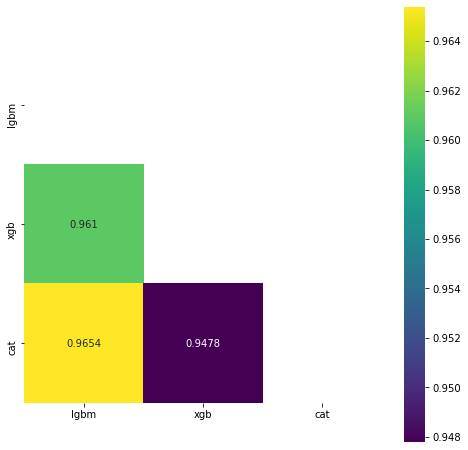

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr_3, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

### Test Correlation

In [30]:
cb_test_preds  = predict_by_estimators(test_encode, cb_estimators)

In [31]:
scores_test_3 = pd.DataFrame({
    "lgbm": lgbm_test_preds["TARGET"],
    "xgb": xgb_test_preds["TARGET"],
    "cat": cb_test_preds["TARGET"],
})

corr_test_3 = scores_test_3.corr()
mask = np.zeros_like(corr_test_3, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<ipython-input-31-5a1da3b8fed1>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_test_3, dtype=np.bool)


<AxesSubplot:>

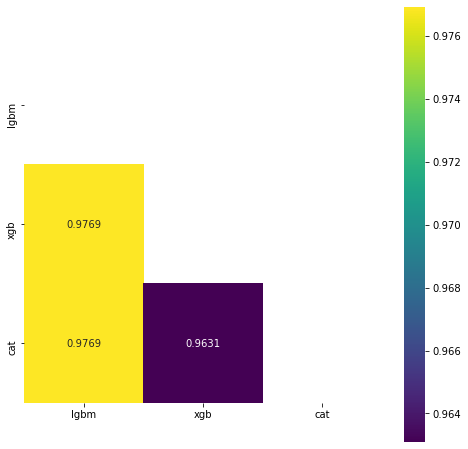

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr_test_3, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

**Вывод**
* Наблюдается высокая корреляция между рассматриваемыми тремя моделями, что свидетельствует о схожей предсказательной силе.
* Корреляция между моделями на тестовой выборке выше, чем на обучающей выборке

## Задание 4
Выполнить задание 2 для трех моделей.

In [33]:
scores_amean = scores_3.mean(axis=1)
auc_amean = roc_auc_score(target, scores_amean)
print(f"AMean Score = {round(auc_amean, 5)}")

scores_gmean = gmean(scores_3, axis=1)
auc_gmean = roc_auc_score(target, scores_gmean)
print(f"GMean Score = {round(auc_gmean, 5)}")

scores_rankdata = scores_3.rank().mean(axis=1)
auc_rankdata = roc_auc_score(target, scores_rankdata)
print(f"Rankdata Score = {round(auc_rankdata, 5)}")

scores_gmean_rankdata = gmean(scores_3.rank(), axis=1)
auc_gmean_rankdata = roc_auc_score(target, scores_gmean_rankdata)
print(f"GMean Rankdata Score = {round(auc_gmean_rankdata, 5)}")

AMean Score = 0.72642
GMean Score = 0.72644
Rankdata Score = 0.72638
GMean Rankdata Score = 0.72637


**Вывод**
* Качество на одиночных моделях составляет: LightGBM - 0.72286, XGBoost - 0.72668, Catboost - 0.724
* Качество усредненных прогнозов AMean - 0.72642, GMean - 0.72644, Rankdata - 0.72638, GMean Rankdata - 0.72637
* Усредненные прогнозы по трем моделям имеют незначительные различия качества метрики. 
* Качество одиночной модели XGBoost немного выше качества метрики усредненных прогнозов по трем моделям. 
* Качествоусредненных прогнозов по трем моделям выше качества усредненных прогнозов по двум моделям.

## Задание 5. (опция)
Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.¶

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
def lr_cross_validation(model, X, y, cv):
    """
    Кросс-валидация для логистической регрессии.

    """
      
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    X = X.fillna(-1)
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
 
        model.fit(X=x_train, y=y_train)
    
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)
               
            
    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [36]:
train_oof_preds = pd.DataFrame(np.vstack((lgbm_oof_preds, xgb_oof_preds, cb_oof_preds)).T,
                                columns=['lgbm', 'xgb', 'cat'])

In [37]:
train_oof_preds.head()

,lgbm,xgb,cat
0,0.019668,0.018412,0.027537
1,0.085944,0.086530,0.085758
2,0.056040,0.057675,0.058633
3,0.192507,0.160854,0.204327
4,0.082735,0.082997,0.082617


In [38]:
lr_clf = LogisticRegression(random_state=seed, solver="liblinear")

lr_estimators, lr_oof_preds = lr_cross_validation(model=lr_clf,
                                                 X=train_oof_preds,
                                                 y=target,
                                                 cv=cv
                                                 )

Sat Oct 30 23:06:05 2021, Cross-Validation, 110093 rows, 3 cols
Fold 1, Valid score = 0.72314
Fold 2, Valid score = 0.7281
Fold 3, Valid score = 0.73396
Fold 4, Valid score = 0.72556
Fold 5, Valid score = 0.72903
Score by each fold: [0.72314, 0.7281, 0.73396, 0.72556, 0.72903]


In [39]:
lr_oof_score = roc_auc_score(target, lr_oof_preds)
print(f"OOF-score = {round(lr_oof_score, 5)}")

OOF-score = 0.72678


**Вывод**
* Качество на одиночных моделях составляет: LightGBM - 0.72286, XGBoost - 0.72668, Catboost - 0.724
* Качество усредненных прогнозов AMean - 0.72642, GMean - 0.72644, Rankdata - 0.72638, GMean Rankdata - 0.72637
* Качество Логистической регрессии, построенной на трех моделях, составляет 0.72678, что немногим выше, чем качество одиночных и усредненных прогнозов.